# Import librerie e dataset preprocessing

In [ ]:
from google.colab import drive
import tarfile
from time import time
from shutil import copyfile
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import random
import pandas as pd
import os
import plotly.express as px
import skimage
import cv2
import imageio
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/Colab Notebooks/COVID-19_Radiography_Dataset.tar', 'COVID-19_Radiography_Dataset.tar')
tar = tarfile.open('COVID-19_Radiography_Dataset.tar')
tar.extractall()
tar.close()

mypath = 'COVID-19_Radiography_Dataset'

Mounted at /content/gdrive


Creazione di nuovo dataset combinando immagini RX e relative mask

In [ ]:
macro_cartelle = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
count = 1
# Elenco i file in base alle macro cartelle
for macro_cartella in macro_cartelle:
    cartella_image = f'{mypath}/{macro_cartella}/images'
    cartella_mask = f'{mypath}/{macro_cartella}/masks'
    cartella_image_mask = f'{mypath}/{macro_cartella}/image_masks'

    files_image = os.listdir(cartella_image)

    # Itero sui file nella sottocartella "image" della macro cartella corrente
    for image in files_image:
        if image in os.listdir(cartella_mask):
            percorso_image = os.path.join(cartella_image, image)
            percorso_mask = os.path.join(cartella_mask, image)

            # Carica le immagini e le adatta in grandezza
            img = cv2.imread(percorso_image, cv2.IMREAD_GRAYSCALE)
            img = img.astype(float) / 255
            mask = cv2.imread(percorso_mask, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img.shape)
            mask = mask.astype(float) / 255

            if img is not None and mask is not None:
                # Eseguo la moltiplicazione puntuale tra le immagini e salvo il risultato nella cartella
                risultato = cv2.multiply(img, mask)*255

                if not os.path.exists(cartella_image_mask):
                    os.makedirs(cartella_image_mask)

                percorso_image_mask = os.path.join(cartella_image_mask, image)
                cv2.imwrite(percorso_image_mask, risultato)

                count = count + 1
                if count%500 == 0:
                  print("...Operazione completata per l'immagine:")
                  print(percorso_image_mask)
                  print(f"caricate {count} immagini con mask.")

            else:
                print(f"Errore nel caricamento delle immagini {image}")

Funzione per creare dataframe train val e test con/senza utilizzo di mask

In [ ]:
# Genero percorsi con labels considerando mask si/no
def define_paths(data_dir, mode_mask):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        # ignoro altri files
        if pathlib.Path(foldpath).suffix != '':
            continue
        lista_files = os.listdir(foldpath)
        for file in lista_files:
            file_path = os.path.join(foldpath, file)
            if pathlib.Path(foldpath).suffix == '':
                # dintinzione tra il caso in cui voglio usare le RX da sole oppure le RX moltiplicate per le mask
                if (mode_mask==1 and (pathlib.Path(file_path).parts[-1] == 'masks' or pathlib.Path(file_path).parts[-1] == 'images')) or \
                   (mode_mask==0 and (pathlib.Path(file_path).parts[-1] == 'masks' or pathlib.Path(file_path).parts[-1] == 'image_masks')):
                    continue
                else:
                    files = os.listdir(file_path)
                    for f in files:
                        filepaths.append(os.path.join(file_path, f))
                        labels.append(fold)
            else:
                filepaths.append(file_path)
                labels.append(fold)

    return filepaths, labels

# Split dataframe in train, valid, and test
def train_val_test_dataframe(data_dir, mode_mask):
    files, classes = define_paths(data_dir, mode_mask)
    File_series = pd.Series(files, name= 'filepaths')
    Label_series = pd.Series(classes, name='labels')
    df = pd.concat([File_series, Label_series], axis= 1)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

Definizione funzione di augmentation direttamente da dataframe

In [ ]:
def datagen(image_dims, color_mode, batch_size, train_df, valid_df, test_df):

  datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,horizontal_flip= True,rotation_range= 15,brightness_range=(0.9, 1.1), zoom_range=[1-0.1, 1+0.1])
  train_gen=datagen.flow_from_dataframe(
                                              dataframe=train_df,
                                              directory=None,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)

  valid_gen=datagen.flow_from_dataframe(
                                              dataframe=valid_df,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)
  # no augmentation per il test set
  datagen_test=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
  test_gen=datagen_test.flow_from_dataframe(
                                              dataframe=test_df,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=False,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)
  return train_gen, valid_gen, test_gen

Definizione funzione per plot etichette

In [ ]:
def count_labels(df):
    label_counts = df.groupby('labels').size()
    label_counts.plot(kind='bar')
    plt.xlabel('Etichette')
    plt.ylabel('Numero di elementi')
    plt.title('Conteggio delle etichette')
    plt.show()

Definizione funzione per visualizzazione immagini

In [ ]:
def visualize_images(df, num_images=9):
    df = df.reset_index(drop=True)
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    axes = axes.ravel()

    for i, index in enumerate(random_indices):
        filepath = df.loc[index, 'filepaths']
        label = df.loc[index, 'labels']
        image = imageio.imread(filepath)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# RX senza mask applicata

In [ ]:
mode_mask = 0
train_df, valid_df, test_df = train_val_test_dataframe(mypath, mode_mask)

In [ ]:
train_df

,filepaths,labels
19542,COVID-19_Radiography_Dataset/COVID/images/COVI...,COVID
16625,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
1633,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Lung_Opacity
8812,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
724,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Lung_Opacity
...,...,...
7962,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
16267,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
11159,COVID-19_Radiography_Dataset/Normal/images/Nor...,Normal
1901,COVID-19_Radiography_Dataset/Lung_Opacity/imag...,Lung_Opacity


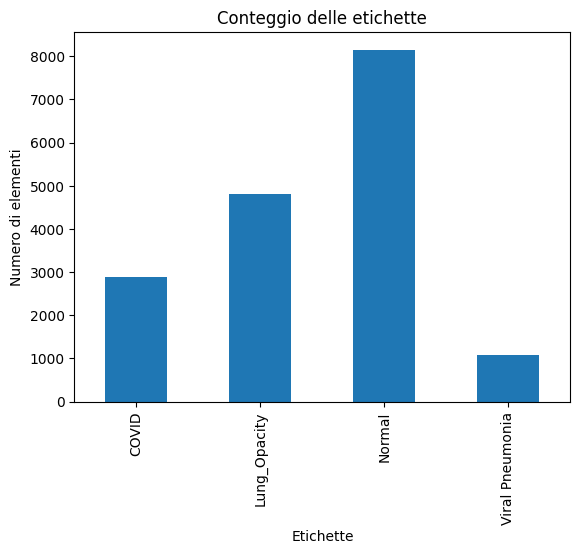

In [ ]:
count_labels(train_df)

<ipython-input-7-78075a770bf6>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


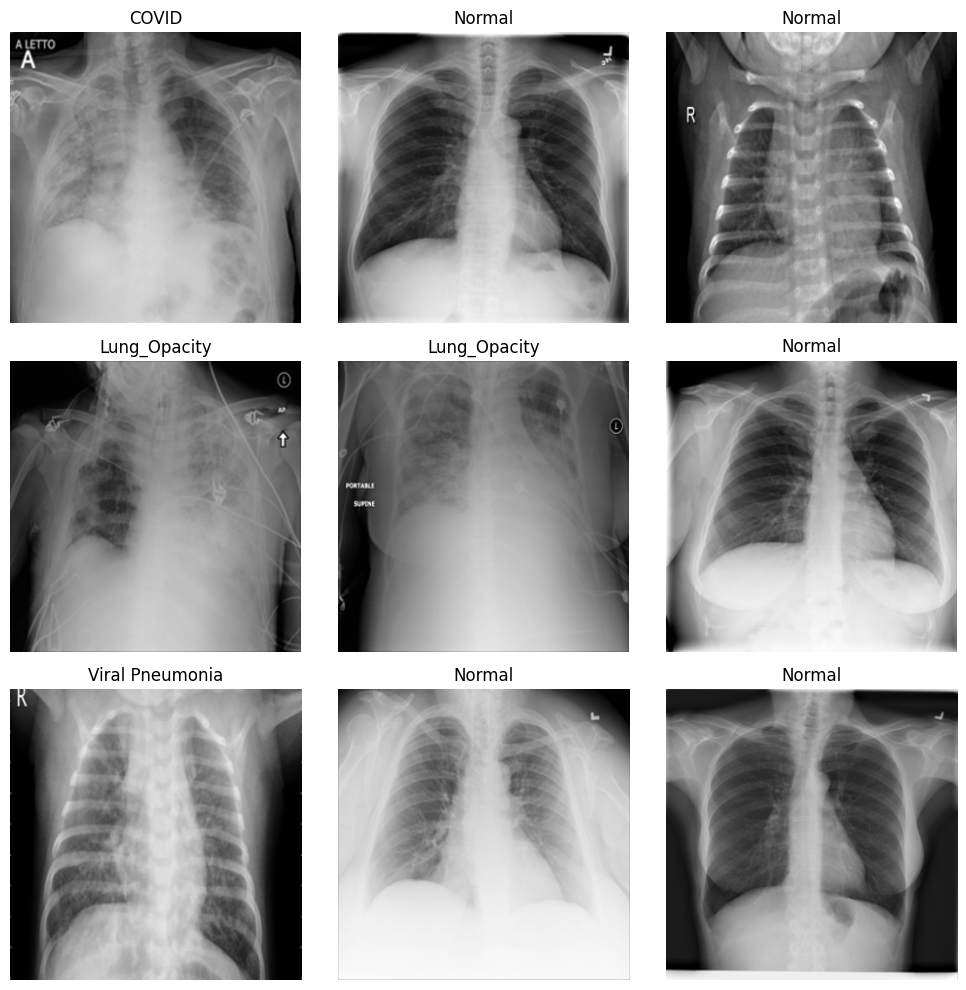

In [ ]:
visualize_images(train_df)

In [ ]:
image_dims = (300,300)
batch_s = 32
train_gen, valid_gen, test_gen = datagen(image_dims, "grayscale", batch_s, train_df, valid_df, test_df )

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [ ]:
inputs = keras.Input((300,300,1))

x = inputs
x = keras.layers.Conv2D(32, 5, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding='same')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Conv2D(64, 5, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(5, strides=5, padding='same')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Conv2D(128, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Conv2D(256, 2, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(units = 16, activation = 'relu')(x)

outputs = keras.layers.Dense(4, activation='softmax')(x)
net = keras.Model(inputs, outputs)
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 32)      832       
                                                                 
 activation (Activation)     (None, 300, 300, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        51264     
                                                             

In [ ]:
# Compile the model for training
net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# salvo pesi iniziali per train successivo con mask
net.save_weights('base_weights_model')

In [ ]:
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_image.hdf5', verbose=1, save_best_only=True)
history = net.fit(x= train_gen, epochs= 25, validation_data= valid_gen, callbacks=[checkpointer])

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.6129
Epoch 1: val_loss improved from inf to 0.76067, saving model to modelli_salvati/cnn_image.hdf5
530/530 [==============================] - 194s 354ms/step - loss: 0.9232 - accuracy: 0.6129 - val_loss: 0.7607 - val_accuracy: 0.6895
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7173
Epoch 2: val_loss improved from 0.76067 to 0.60767, saving model to modelli_salvati/cnn_image.hdf5
530/530 [==============================] - 187s 354ms/step - loss: 0.7062 - accuracy: 0.7173 - val_loss: 0.6077 - val_accuracy: 0.7703
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.6031 - accuracy: 0.7646
Epoch 3: val_loss improved from 0.60767 to 0.57154, saving model to modelli_salvati/cnn_image.hdf5
530/530 [==============================] - 186s 350ms/step - loss: 0.6031 - accuracy: 0.7646 - val_loss: 0.5715 - val_accuracy: 0.7798
Epoch 4/25
530

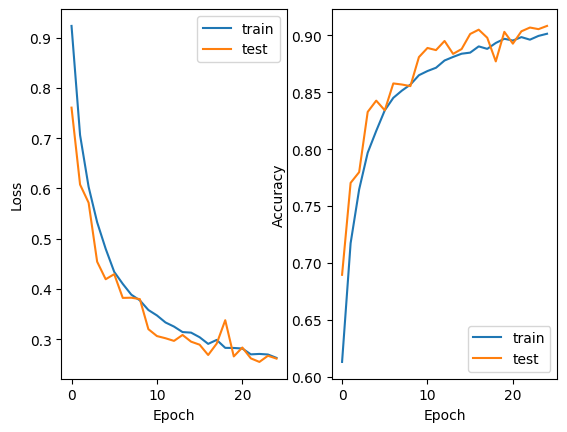

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
#net = keras.models.load_model('modelli_salvati/cnn_image.hdf5')
net = keras.models.load_model('gdrive/My Drive/Colab Notebooks/cnn_image.hdf5')

In [ ]:
preds = net.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-14-7d2394be2bcd>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = net.predict_generator(test_gen)


                 precision    recall  f1-score   support

          COVID       0.94      0.91      0.93       362
   Lung_Opacity       0.89      0.81      0.85       602
         Normal       0.88      0.95      0.91      1019
Viral Pneumonia       0.96      0.93      0.95       134

       accuracy                           0.90      2117
      macro avg       0.92      0.90      0.91      2117
   weighted avg       0.90      0.90      0.90      2117

[[330  17  13   2]
 [ 10 485 106   1]
 [ 10  41 966   2]
 [  0   0   9 125]]


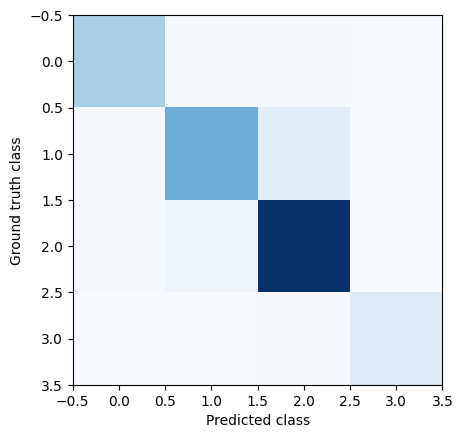

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))
print(cm)

# RX con mask applicata

In [ ]:
mode_mask = 1
train_df, valid_df, test_df = train_val_test_dataframe(mypath, mode_mask)

<ipython-input-7-78075a770bf6>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filepath)


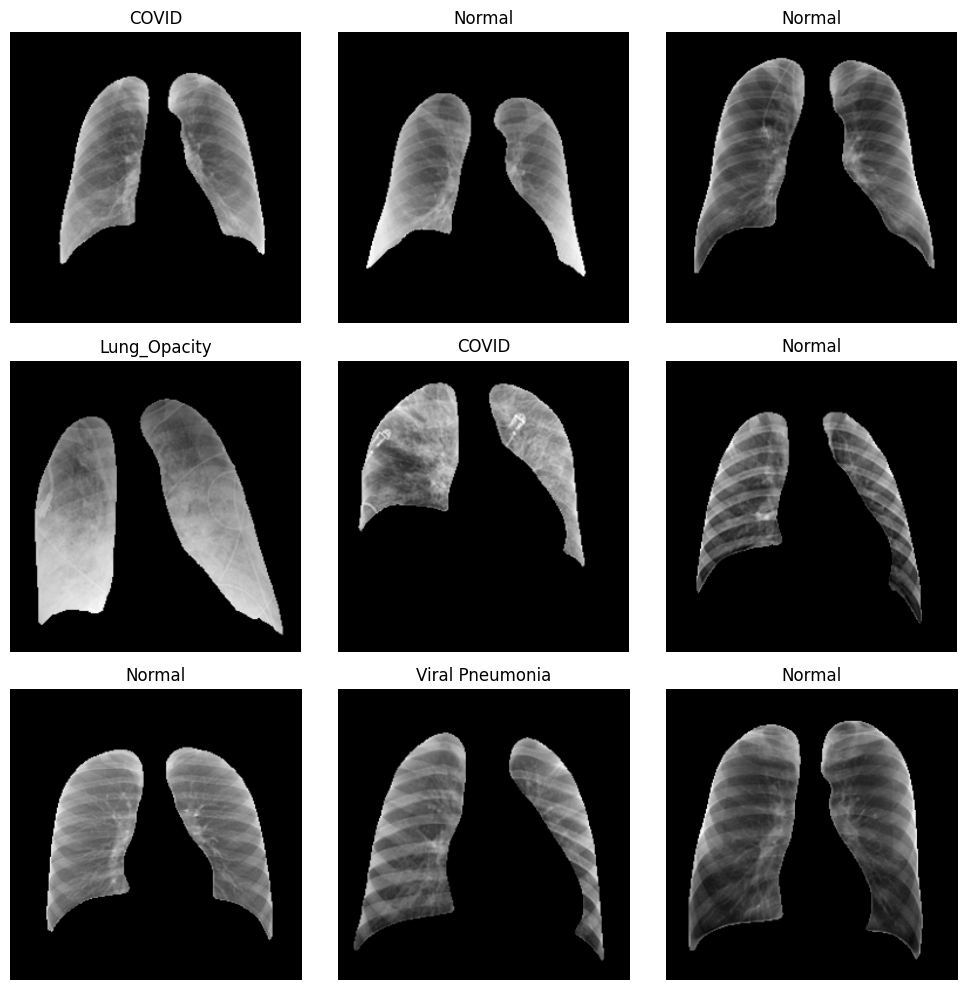

In [ ]:
visualize_images(train_df)

In [ ]:
image_dims = (300,300)
batch_s = 32
train_gen, valid_gen, test_gen = datagen(image_dims, "grayscale", batch_s, train_df, valid_df, test_df )

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [ ]:
net.load_weights('base_weights_model')

In [ ]:
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_imageANDmask.hdf5', verbose=1, save_best_only=True)
history = net.fit(x= train_gen, epochs= 25, validation_data= valid_gen, callbacks=[checkpointer])

Epoch 1/25
530/530 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.6746
Epoch 1: val_loss improved from inf to 0.69597, saving model to modelli_salvati/cnn_imageANDmask.hdf5
530/530 [==============================] - 169s 304ms/step - loss: 0.8297 - accuracy: 0.6746 - val_loss: 0.6960 - val_accuracy: 0.7287
Epoch 2/25
530/530 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.7261
Epoch 2: val_loss improved from 0.69597 to 0.66442, saving model to modelli_salvati/cnn_imageANDmask.hdf5
530/530 [==============================] - 156s 295ms/step - loss: 0.6945 - accuracy: 0.7261 - val_loss: 0.6644 - val_accuracy: 0.7335
Epoch 3/25
530/530 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.7448
Epoch 3: val_loss improved from 0.66442 to 0.65197, saving model to modelli_salvati/cnn_imageANDmask.hdf5
530/530 [==============================] - 157s 296ms/step - loss: 0.6485 - accuracy: 0.7448 - val_loss: 0.6520 - val_accuracy: 

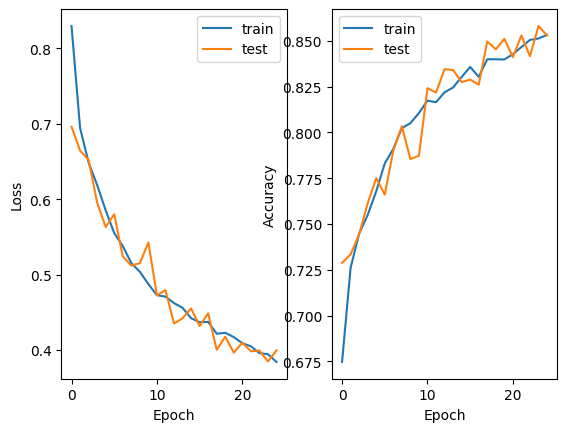

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
#net = keras.models.load_model('modelli_salvati/cnn_imageANDmask.hdf5')

In [ ]:
net = keras.models.load_model('gdrive/My Drive/Colab Notebooks/cnn_imageANDmask.hdf5')

In [ ]:
preds = net.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<ipython-input-27-7d2394be2bcd>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = net.predict_generator(test_gen)


                 precision    recall  f1-score   support

          COVID       0.82      0.66      0.73       362
   Lung_Opacity       0.85      0.80      0.82       602
         Normal       0.86      0.95      0.90      1019
Viral Pneumonia       0.93      0.93      0.93       134

       accuracy                           0.86      2117
      macro avg       0.86      0.83      0.85      2117
   weighted avg       0.85      0.86      0.85      2117

[[238  59  65   0]
 [ 31 481  85   5]
 [ 19  28 967   5]
 [  1   1   7 125]]


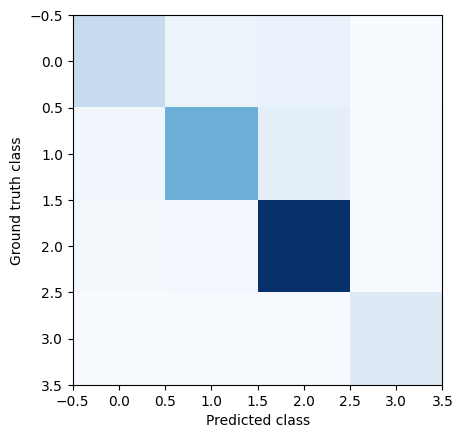

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))
print(cm)

# ResNet (no mask)

Ridefinizione di datagen con funzione di preprocess di resnet

In [ ]:
from keras.applications.resnet_v2 import preprocess_input
def datagen2(image_dims, color_mode, batch_size, train_df, valid_df, test_df):

  datagen=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,horizontal_flip= True,rotation_range= 15,brightness_range=(0.9, 1.1), zoom_range=[1-0.1, 1+0.1])
  train_gen=datagen.flow_from_dataframe(
                                              dataframe=train_df,
                                              directory=None,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)

  valid_gen=datagen.flow_from_dataframe(
                                              dataframe=valid_df,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=True,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)
  # no augmentation per il test set
  datagen_test=tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
  test_gen=datagen_test.flow_from_dataframe(
                                              dataframe=test_df,
                                              x_col="filepaths",
                                              y_col="labels",
                                              batch_size=batch_size,
                                              shuffle=False,
                                              class_mode="categorical",
                                              color_mode= color_mode,
                                              target_size=image_dims)
  return train_gen, valid_gen, test_gen

In [ ]:
mode_mask = 0
train_df, valid_df, test_df = train_val_test_dataframe(mypath, mode_mask)

In [ ]:
image_dims = (224,224)
batch_s = 128
train_gen, valid_gen, test_gen = datagen2(image_dims, "rgb", batch_s, train_df, valid_df, test_df )

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [ ]:
from keras.applications.resnet_v2 import ResNet50V2

ResNet50_net = ResNet50V2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='max')

layer_name = 'conv4_block4_out'
trainable = False
for layer in ResNet50_net.layers:
    if layer.name == layer_name:
        trainable = True
    layer.trainable = trainable


resnet_output = ResNet50_net.output
x = keras.layers.Flatten()(resnet_output)
x = keras.layers.Dense(units = 1028, activation = 'relu')(x)
x = keras.layers.Dense(units = 512, activation = 'relu')(x)
x = keras.layers.Dense(units = 32, activation = 'relu')(x)


fc_layer = keras.layers.Dense(4, activation='softmax')(x)

# Crea il modello finale
net = keras.models.Model(inputs=ResNet50_net.input, outputs=fc_layer)

94668760/94668760 [==============================] - 5s 0us/step


In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='modelli_salvati/cnn_imageResNet.hdf5', verbose=1, save_best_only=True)
history = net.fit(x= train_gen, epochs= 10, validation_data= valid_gen, callbacks=[checkpointer])

Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.8044
Epoch 1: val_loss improved from inf to 1.00594, saving model to modelli_salvati/cnn_imageResNet.hdf5
133/133 [==============================] - 348s 2s/step - loss: 0.8677 - accuracy: 0.8044 - val_loss: 1.0059 - val_accuracy: 0.8322
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9117
Epoch 2: val_loss improved from 1.00594 to 0.28134, saving model to modelli_salvati/cnn_imageResNet.hdf5
133/133 [==============================] - 307s 2s/step - loss: 0.2519 - accuracy: 0.9117 - val_loss: 0.2813 - val_accuracy: 0.9078
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9262
Epoch 3: val_loss improved from 0.28134 to 0.26276, saving model to modelli_salvati/cnn_imageResNet.hdf5
133/133 [==============================] - 306s 2s/step - loss: 0.2074 - accuracy: 0.9262 - val_loss: 0.2628 - val_accuracy: 0.9121
Epoch

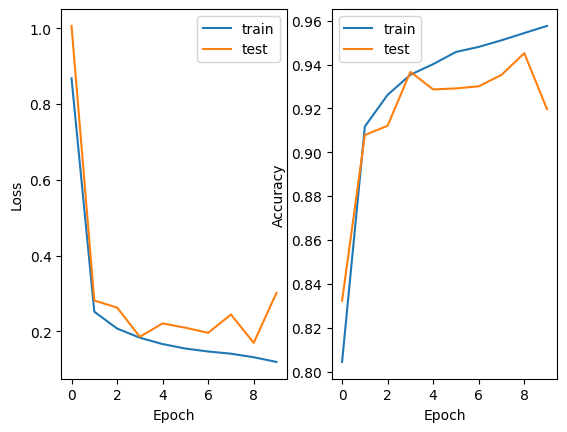

In [ ]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
# utilizzo il modello migliore (loss minore nel val test), ottenuto durante il training
net = keras.models.load_model('modelli_salvati/cnn_imageResNet.hdf5')

In [ ]:
net = keras.models.load_model('gdrive/My Drive/Colab Notebooks/cnn_imageResNet.hdf5')

In [ ]:
preds = net.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

17/17 [==============================] - 15s 780ms/step


                 precision    recall  f1-score   support

          COVID       0.98      0.95      0.97       362
   Lung_Opacity       0.95      0.88      0.91       602
         Normal       0.92      0.98      0.95      1019
Viral Pneumonia       0.99      0.93      0.96       134

       accuracy                           0.94      2117
      macro avg       0.96      0.94      0.95      2117
   weighted avg       0.94      0.94      0.94      2117

[[345  10   7   0]
 [  5 529  68   0]
 [  3  18 997   1]
 [  0   0   9 125]]


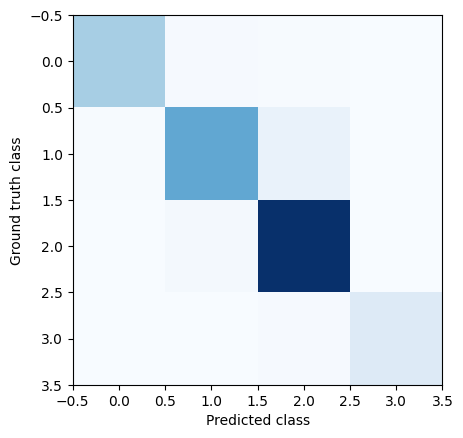

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))
print(cm)

Salvataggio modelli su gdrive

In [ ]:
!cp -r "/content/modelli_salvati" "/content/gdrive/MyDrive/Colab Notebooks"